In [8]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [9]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [10]:
def build_generator():   
    
    noise_shape = (100,) 

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    

    return Model(noise, img)



In [11]:
def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [12]:


def train(epochs, batch_size=128, save_interval=50):

    (X_train, _), (_, _) = mnist.load_data()

    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)



    
    for epoch in range(epochs):


        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        gen_imgs = generator.predict(noise)

       
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
   
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 


        noise = np.random.normal(0, 1, (batch_size, 100)) 

       
        valid_y = np.array([1] * batch_size) 

       
        g_loss = combined.train_on_batch(noise, valid_y)



        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        if epoch % save_interval == 0:
            save_imgs(epoch)


In [26]:


def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/sample_data/mnist_%d.png" % epoch)
    plt.close()



In [28]:

optimizer = Adam(0.0002, 0.5) 


discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

 
z = Input(shape=(100,)) 
img = generator(z)

 
discriminator.trainable = False  


valid = discriminator(img)  



combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=1000, batch_size=32, save_interval=10)



generator.save('generator_model.h5') 


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_41 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-t

In [30]:
from keras.models import load_model
model_new = load_model('/content/generator_model.h5')

1/1 [==============================] - 0s 17ms/step


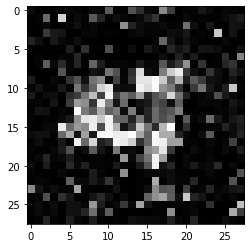

In [41]:
from numpy.random import randn
x = randn(100)
x = x.reshape(1,100)

pred = model_new.predict(x)


plt.imshow(pred[0,:,:,0], cmap = 'gray')